In [1]:
# import package to make HTTP requests, i.e. fetch URL similar to a browser request
import requests
#import json library to decode JSON
import json
#Import for data manipulation and analysis 
import pandas as pd
from sqlalchemy import create_engine

In [2]:
!pip install pandas

In [15]:
# Set Up Database Connection
from sqlalchemy import create_engine

In [29]:
# Read database connection details from file
with open('/Users/lilyboses/Desktop/SQL/AWS_RDS.txt', 'r') as f:
    lines = f.readlines()
    username = lines[0].strip()
    password = lines[1].strip()
    host = lines[2].strip()
    database = lines[3].strip()

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}')

In [30]:

# Read API key from file
with open('/Users/lilyboses/nyt_api_key.txt', 'r') as f:
    API_KEY = f.read().strip()
BASE_URL = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

In [18]:
# Define a function to perform the API search
# This function takes in a search query and an API key and returns the JSON response from the NYT Article Search API.
def nyt_article_search(query, api_key):
    params = {'q': query, 'api-key': api_key}
    response = requests.get(BASE_URL, params=params)
    return response.json()

In [19]:
# Main execution: Perform a search query and store the results
query = "Paramount"  # Example search term
search_results = nyt_article_search(query, API_KEY)

# Assuming 'docs' contains the list of articles
articles_data = search_results.get('response', {}).get('docs', [])
articles_df = pd.DataFrame(articles_data)


In [20]:
# Parse the articles from the API response
def parse_articles(response_json):
    # Extract the articles
    articles = response_json['response']['docs']
    # Define the information to be stored for each article
    articles_data = [{
        'headline': article['headline']['main'],
        'snippet': article['snippet'],
        'pub_date': article['pub_date'],
        'document_type': article['document_type'],
        'news_desk': article['news_desk'],
        'section_name': article['section_name'],
        'web_url': article['web_url'],
        'word_count': article['word_count']
    } for article in articles]
    # Convert to DataFrame
    return pd.DataFrame(articles_data)

df_articles = parse_articles(search_results)

In [21]:
# Convert publication date to datetime object
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])

# Check for missing values and handle them
df_articles = df_articles.dropna(subset=['section_name', 'headline'])

# extracting the year and month of publication for trend analysis
df_articles['year'] = df_articles['pub_date'].dt.year
df_articles['month'] = df_articles['pub_date'].dt.month


In [22]:
# Analyze trends over time
trends_over_time = df_articles.groupby(['year', 'month']).size()

# Analyze article distribution by section
section_distribution = df_articles['section_name'].value_counts()


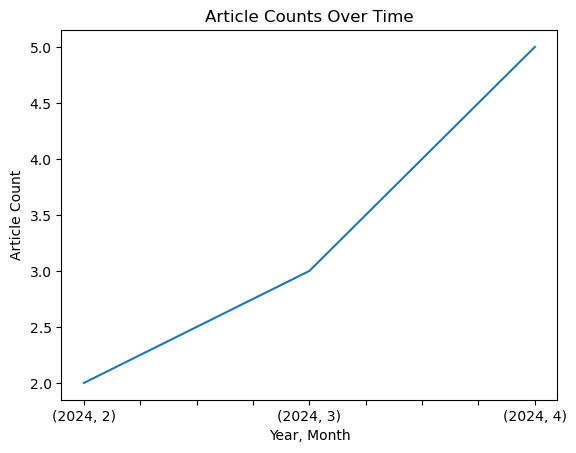

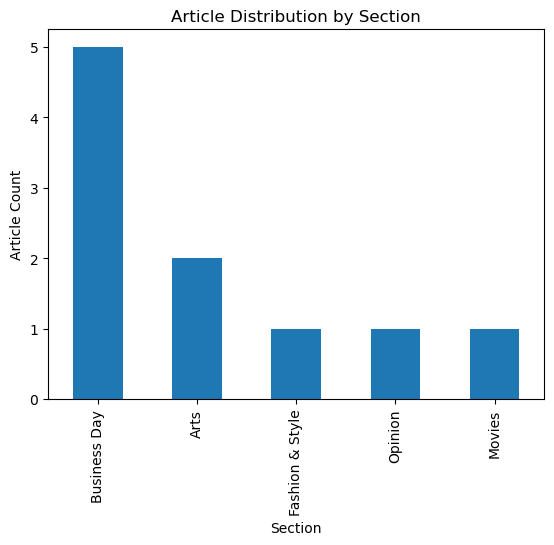

In [16]:
import matplotlib.pyplot as plt

# Trend over time
trends_over_time.plot(title='Article Counts Over Time')
plt.xlabel('Year, Month')
plt.ylabel('Article Count')
plt.show()

# Section distribution
section_distribution.plot(kind='bar', title='Article Distribution by Section')
plt.xlabel('Section')
plt.ylabel('Article Count')
plt.show()


In [33]:

csv_file_path = '/Users/lilyboses/Desktop/SQL/nyt_articles.csv'
df_articles.to_csv(csv_file_path, index=False)

# Now df_articles is saved as a CSV file at the specified path
print(f"Data saved to {csv_file_path}")


Data saved to /Users/lilyboses/Desktop/SQL/nyt_articles.csv
